In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

body_part = "shoulder_left"
file_names = [
    './training_data/val_fb_sfast_dvbf_medium.bag'
#     './training_data/val_fb_fast_gt.csv'
]
# file_names = ['./training_data/shoulder_left_train_2.log',
#               './training_data/shoulder_left_train_5_6_7_9_10.log'
#              ]
# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
# orig_dataset = pd.concat([pd.read_csv(f, header=0) for f in file_names])
# orig_dataset = orig_dataset.values[1:len(orig_dataset)-2,1:]

abnormal_threshold = 0.5
dataset = []
orig_dataset = []

euler_idxs = ["position_0", "position_1", "position_2"]
action_idxs = ["cf_velocity_0", "cf_velocity_1", "cf_velocity_2"]
magnetic_idxs = [f'{coord}_{id}' for id in range(4) for coord in ['x','y','z']]

for name in file_names:
    df = pd.read_csv(name, header=0)
    
#     df['date'] = pd.to_datetime(df.Time, unit='s')
#     df.groupby(pd.Grouper(key='date', freq='20L')).mean().interpolate()

    orig_dataset.append(df.copy())
    
    # interpolate nan outputs (loss tracking)
    for c in euler_idxs:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
#     for c in magnetic_idxs:
#         bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
#         df.loc[bad_idx, c] = np.nan
#         df[c] = df[c].interpolate()
    
#     # Add action
#     for c in df.columns[-3:]:
#         df["dt"] = (df["Time"][1:].tolist() - df["Time"][:-1])
#         df[c + "_u"] = (df[c][1:].tolist() - df[c][:-1]) / df["dt"]
    
#     # Remove last row
#     df = df[:-1]
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 
orig_dataset = pd.concat(orig_dataset)

print(f'{np.sum(dataset_len)} values')

dataset = dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]
orig_dataset = orig_dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]

# dataset = dataset[abs(dataset[:,12])!=0.0,:]
# dataset = dataset[abs(dataset[:,13])!=0.0,:]
# dataset = dataset[abs(dataset[:,14])!=0.0,:]

# print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
action_set = dataset[:, 15:]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

15047 values
max euler 0.4048930652052869
min euler -2.039221058094067


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [5]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [6]:
# model_path = f"./outputs_idp/local_shoulder_left_lstm_rot6D"
model_path = f"./outputs_idp_isrr/shoulder_left_lstm_rot6D"

sensors_scaler, action_scaler = joblib.load(f'{model_path}/scaler.pkl')

In [7]:
orig_sensors_set = sensors_scaler.transform(orig_sensors_set)
sensors_set = sensors_scaler.transform(sensors_set)
action_set = action_scaler.fit_transform(action_set)

In [8]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import LSTMRegressor, mse_seq

In [9]:
with open(f'{model_path}/hyperparams.json', 'r') as fp:
    p = json.load(fp)

In [10]:
model = LSTMRegressor.load_from_checkpoint(checkpoint_path=f"{model_path}/best.ckpt")

In [11]:
device = "cpu"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

LSTMRegressor(
  (lstm): LSTM(12, 100, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=100, out_features=6, bias=True)
  (tanh): Tanh()
)

In [12]:
# sen_in = sensors_set[None]
# in_set = torch.tensor(sen_in, dtype=torch.float32).to(device)
# out_set = model(in_set)[0]

look_back = 5
in_set = []
for i in range(0, len(orig_sensors_set) - look_back):
    in_set.append(orig_sensors_set[i:i+look_back])

in_set = torch.tensor(in_set, dtype=torch.float32).to(device)
out_set = model(in_set)[:, -1]

rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

In [13]:
test_euler_set = dataset[:, 12:15]
time_arr = np.arange(len(out_set))#[6500:7500]
plt_prefix = "ts_6k5-7k5"

euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred).cpu().detach().numpy()[time_arr]
euler_gt = torch.tensor(test_euler_set, dtype=torch.float32).to(device).cpu().detach().numpy()[time_arr]

In [14]:
plt.rc('font', size=18)

<IPython.core.display.Javascript object>


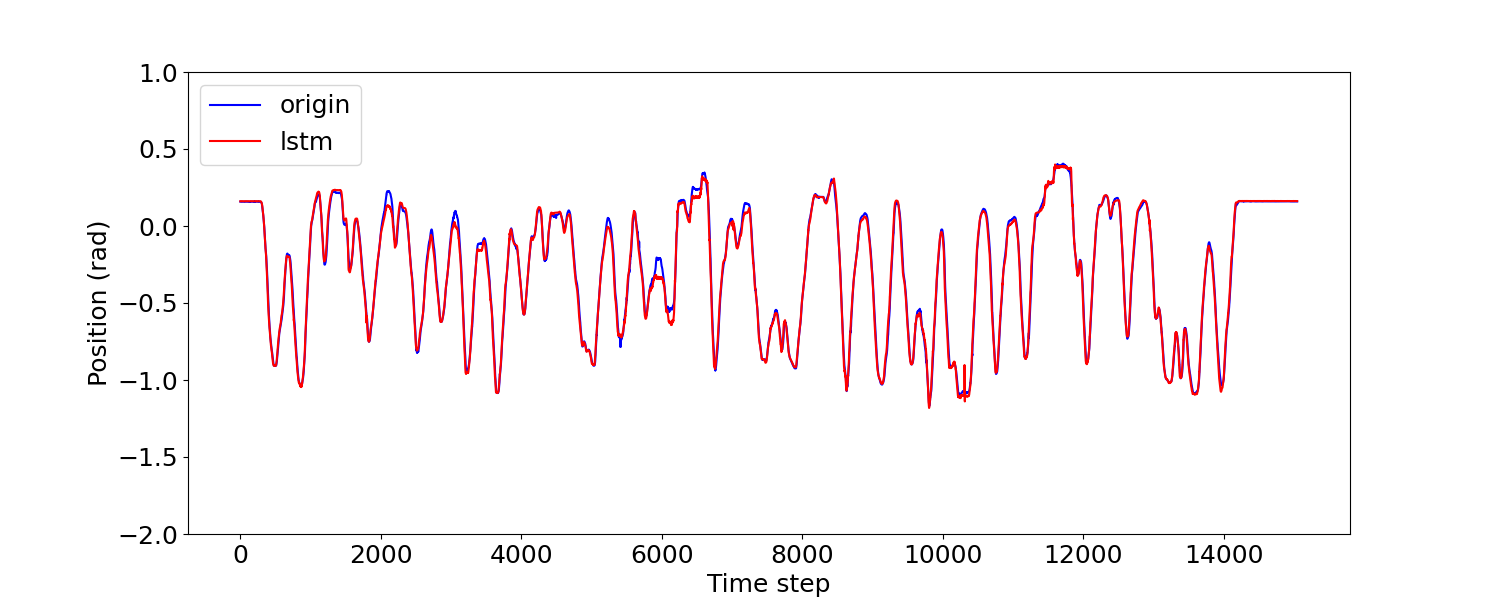

In [21]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 0], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 0], c="red", label="lstm")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_lstm_euler_0.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


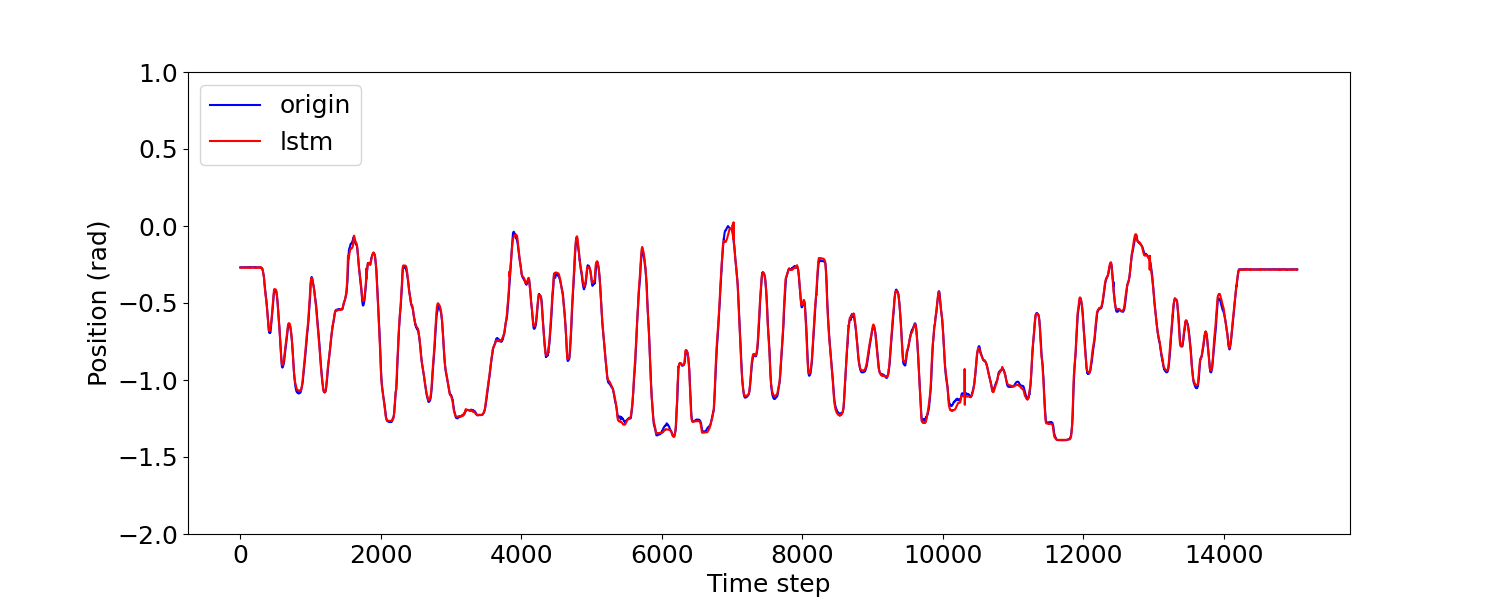

In [22]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 1], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 1], c="red", label="lstm")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_lstm_euler_1.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


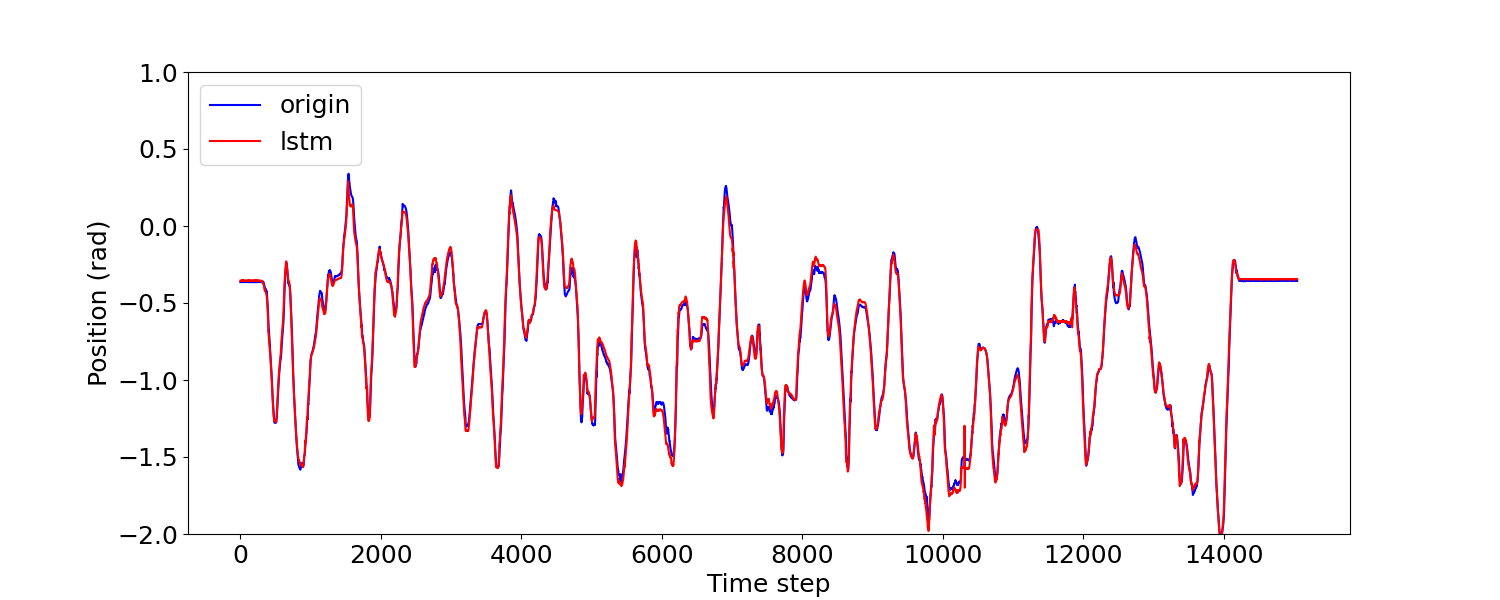

In [23]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 2], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 2], c="red", label="lstm")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_lstm_euler_2.pdf', dpi=100, bbox_inches='tight')